# Team Panda | data anonymisation and security sharing project
iInsureU123, a health insurance start-up, consulting us for data anonymisation and security sharing. 

## Setting up the environment

### Importing packages and data

In [1]:
# Importing packages
import random
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
import pycountry_convert as pc
import seaborn as sns
sns.set()

# Importing the data
data = pd.read_csv('customer_information.csv')

### Functions

In [2]:
# Function to see the distribution in each variable
def plot_column_counts_with_annotations(data, variable, rotation_degree=0):
    # Counting unique values in the specified column
    counts = data[variable].value_counts()
    variable_name = variable.replace("_"," ")
    # Plotting the counts as a bar graph
    ax = counts.plot(kind='bar')
    plt.xlabel(variable_name)
    plt.ylabel("Counts")
    plt.title(f"Distribution of {variable_name}")
    plt.xticks(rotation=rotation_degree)

    # Annotating the bar graph with the counts
    for i, count in enumerate(counts):
        ax.annotate(str(count), (i, count), ha='center', va='bottom', xytext=(0, 0), textcoords='offset points')

    plt.show()

# Anonymising names into sampleID

In [3]:
# Function to generate sample ids
def generate_sample_id(index):
    return f"sid_{str(index + 1).zfill(5)}"

# Applying function to generate the column "sample ID"
data['sample_ID'] = data.index.to_series().apply(generate_sample_id)

# Banding birth year for government

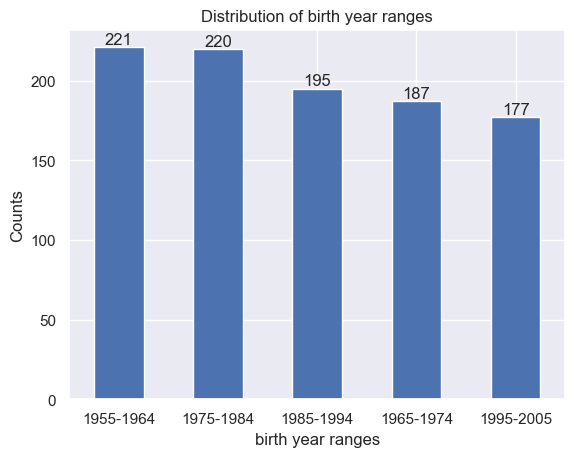

In [4]:
# Converting birth date to birth year
birthDate = pd.to_datetime(data.birthdate, format='mixed')
data['birth_year'] = pd.DatetimeIndex(birthDate).year

# Looking at the min and max of birth year
min_birthyear = data['birth_year'].min() # 1955
max_birthyear = data['birth_year'].max() # 2005

# Creating groups with 10 years range
birthyear_bins = ["1955", "1965", "1975", "1985", "1995", "2005"]
birthyear_labels = ["1955-1964", "1965-1974", "1975-1984","1985-1994","1995-2005" ]

# Banding heights into specified ranges
data['birth_year_ranges'] = pd.cut(data['birth_year'], bins=birthyear_bins, labels=birthyear_labels, right=False)

# Showing counts of height ranges
plot_column_counts_with_annotations(data, 'birth_year_ranges')

# Banding postcodes into regions for government and researchers

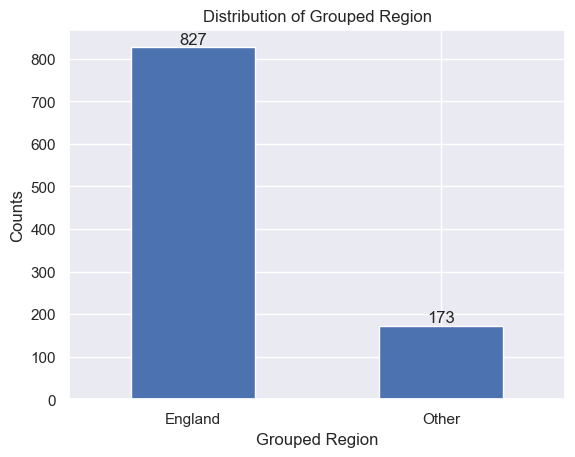

In [5]:
# Function to truncate postcode after the first numeric digit
def truncate_postcode(postcode):
    for i, char in enumerate(postcode):
        if char.isdigit():
            return postcode[:i]  # Truncate at the position of the first numeric digit
    return postcode  # Return the original postcode if no numeric digit is found

# Applying the function to create the postcode bands
data['postcode'] = data['postcode'].astype(str).apply(truncate_postcode)

# Importing postcode mapping to region
postcode_values = pd.read_excel('PostcodeRegions.xlsx')

# Making it into a dictionary
postcode_dict = postcode_values.set_index('Postcode Area')['Region'].to_dict()

# Applying the mapping to the dataframe
data['Region'] = data['postcode'].map(postcode_dict)

# Dictionary for mapping regions to 'England' or 'Other'
region_mapping = {
    'Greater London': 'England',
    'North West': 'England',
    'East Midlands': 'England',
    'West Midlands': 'England',
    'South East': 'England',
    'South West': 'England',
    'East of England': 'England',
    'North East': 'England',
    'East England': 'England',
    'Scotland': 'Other',
    'Wales': 'Other',
    'Channel Islands': 'Other',
    'Northern Ireland': 'Other',
    'Isle of Man': 'Other'
}

# Creating a new column with the mapped values
data['Grouped_Region'] = data['Region'].map(region_mapping)

plot_column_counts_with_annotations(data, 'Grouped_Region')

# Banded education for government

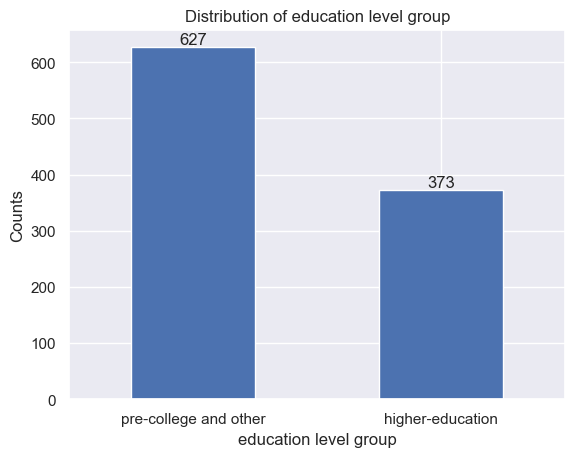

In [6]:
# Grouping Education level together
education_replacements = {
    'primary': 'pre-college and other',
    'secondary': 'pre-college and other',
    'bachelor': 'higher-education',
    'masters': 'higher-education',
    'phD': 'higher-education',
    'other': 'pre-college and other'
}

# Applying the education grouping to the column "education_level"
data['education_level_group'] = data['education_level'].map(education_replacements)

plot_column_counts_with_annotations(data, 'education_level_group')

# Generating final datasets

In [7]:
# Order of columns:
cols_gov = ['sample_ID', 'gender','birth_year_ranges', 'current_country', 'Grouped_Region', 'weight', 'height', 'blood_group', 'avg_n_drinks_per_week', 'avg_n_cigret_per_week', 'education_level_group', 'n_countries_visited','cc_status']
cols_res = ['sample_ID', 'gender','birth_year', 'country_of_birth', 'current_country', 'Region', 'weight', 'height', 'blood_group', 'avg_n_drinks_per_week', 'avg_n_cigret_per_week', 'education_level', 'n_countries_visited','cc_status']

In [11]:
# Generating final dataset for gov/public and researchers
final_data_gov = data[cols_gov]
final_data_res = data[cols_res]

# Exporting
final_data_gov.to_csv("Anonymised_government_dataset.csv", index=False)
final_data_res.to_csv("Anonymised_researcher_dataset.csv", index=False)

# Calculating k-anonymity

In [15]:
k_anon_gov_dataset = pd.read_csv('Anonymised_government_dataset.csv')
k_anon_res_dataset = pd.read_csv('Anonymised_researcher_dataset.csv')

k_anon_res_dataset.head(10)

,sample_ID,gender,birth_year,continent_of_birth,current_country,Region,weight,height,blood_group,avg_n_drinks_per_week,avg_n_cigret_per_week,education_level,n_countries_visited,cc_status
0,sid_00001,F,1984,Asia,United Kingdom,North East,74.2,1.73,B+,6.5,218.8,phD,48,0
1,sid_00002,M,1997,Oceania,United Kingdom,North West,69.4,1.74,O-,0.7,43.6,primary,42,0
2,sid_00003,F,1990,South America,United Kingdom,South East,98.6,1.88,B+,7.8,59.1,bachelor,9,0
3,sid_00004,F,2000,Africa,United Kingdom,West Midlands,62.0,1.56,O+,4.6,284.2,primary,32,0
4,sid_00005,F,1968,South America,United Kingdom,South West,96.3,1.81,A-,4.4,348.8,secondary,34,0
5,sid_00006,F,1963,South America,United Kingdom,East of England,43.4,1.59,A-,5.7,219.3,other,7,0
6,sid_00007,M,1982,Oceania,United Kingdom,North West,77.5,1.55,B+,2.4,79.5,secondary,34,0
7,sid_00008,M,1987,North America,United Kingdom,Greater London,59.0,1.89,A+,8.4,48.0,other,24,0
8,sid_00009,F,1999,Oceania,United Kingdom,West Midlands,83.1,1.42,A+,1.2,148.1,secondary,17,0
9,sid_00010,M,1998,North America,United Kingdom,Greater London,80.0,1.74,A+,5.2,47.0,bachelor,47,0


In [24]:
# Identifying the quasi-identifiers for both datasets
# Government
quasi_identifiers_gov = ['gender', 'birth_year_ranges','current_country', 'education_level_group','Grouped_Region']
# Researchers
quasi_identifiers_res = ['gender', 'birth_year','continent_of_birth', 'current_country', 'Region', 'education_level']

# Calculating k-anonymity for government
gov_groups = k_anon_gov_dataset.groupby(quasi_identifiers_gov).size()
print("K-anonymity for the government dataset is:", gov_groups.min())
# Calculating k-anonymity for researchers
res_groups = k_anon_res_dataset.groupby(quasi_identifiers_res).size()
print("K-anonymity for the researcher dataset is:", res_groups.min())


K-anonymity for the government dataset is: 4
K-anonymity for the researcher dataset is: 1


# Encrypting Direct Identifiers with Key for Team Panda

In [ ]:
# Using Fernet to perfrom encryption
from cryptography.fernet import Fernet

# Function that encrypts a column with a key to be able to reverse encryption if needed by researchers
def encrypt_column(column, key):
    fernet = Fernet(key)
    return column.apply(lambda x: fernet.encrypt(str(x).encode()).decode())

# Generating an encryption key and then encrypting the direct identifier columns from original data
key = Fernet.generate_key()
columns_encrypting = ['national_insurance_number', 'phone_number', 'bank_account_number']

# Creating new data frame that includes our assigned unique sample_ids for encrypted data
# Allows decryption to be performed using a key and referencing sample_id
encrypted_customer_information = data[['sample_ID']].copy()

# Encrypting the columns and adding them to the new data frame, followed by
# Saving the new data frame that is encrypted to a new CSV file
for col in columns_encrypting:
    encrypted_customer_information[col] = encrypt_column(data[col], key)
encrypted_customer_information.to_csv('encrypted_customer_information_with_sample_id.csv', index=False)

# Saving the key of encryption to a file in case decryption is needed later
with open('encryption_key.txt', 'wb') as key_file:
    key_file.write(key)

# Checking encryption by printing first several rows of the new data frame
print(encrypted_customer_information.head())

#### This remaining portion of code is to decrypt the data, that we, Team Panda, would use if researchers needed any of the direct identifier information for a notable reason

In [ ]:
# Function for column decryption using the key
def decrypt_column(column, key):
    fernet = Fernet(key)
    return column.apply(lambda x: fernet.decrypt(x.encode()).decode())

# Loading the key for the encryption that was previously created
with open('encryption_key.txt', 'rb') as key_file:
    key = key_file.read()

# Loading the previously encrypted data frame, followed by 
# specifying the columns that were previously encrypted, that will now be decrypted
encrypted_data = pd.read_csv('encrypted_customer_information_with_sample_id.csv')
columns_decrypting = ['national_insurance_number', 'phone_number', 'bank_account_number']

# Decrypting those specified columns and updating the data frame
for col in columns_decrypting:
    encrypted_data[col] = decrypt_column(encrypted_data[col], key)

# The new data frame should now have the data in decrypted format
print(encrypted_data.head())